In [5]:
import pandas as pd
import numpy as np
import re
import regex
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

from underthesea import word_tokenize, pos_tag, sent_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [6]:
from os import truncate
# Bước 1: đọc dữ liệu
data = pd.read_excel("/content/gdrive/MyDrive/DL07/Project1/data/Reviews.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/DL07/Project1/data/Reviews.xlsx'

In [ ]:
data.head(3)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8417 entries, 0 to 8416
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           8417 non-null   int64 
 1   Company Name                 8417 non-null   object
 2   Cmt_day                      8417 non-null   object
 3   Title                        8417 non-null   object
 4   What I liked                 8416 non-null   object
 5   Suggestions for improvement  8412 non-null   object
 6   Rating                       8417 non-null   int64 
 7   Salary & benefits            8417 non-null   int64 
 8   Training & learning          8417 non-null   int64 
 9   Management cares about me    8417 non-null   int64 
 10  Culture & fun                8417 non-null   int64 
 11  Office & workspace           8417 non-null   int64 
 12  Recommend?                   8417 non-null   object
dtypes: int64(7), object(6)
memory usa

In [ ]:
data.isnull().sum()

,0
id,0
Company Name,0
Cmt_day,0
Title,0
What I liked,1
Suggestions for improvement,5
Rating,0
Salary & benefits,0
Training & learning,0
Management cares about me,0


In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
data = data.dropna()

In [ ]:
data.count()

,0
id,8411
Company Name,8411
Cmt_day,8411
Title,8411
What I liked,8411
Suggestions for improvement,8411
Rating,8411
Salary & benefits,8411
Training & learning,8411
Management cares about me,8411


In [ ]:
data.columns

Index(['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked',
       'Suggestions for improvement', 'Rating', 'Salary & benefits',
       'Training & learning', 'Management cares about me', 'Culture & fun',
       'Office & workspace', 'Recommend?'],
      dtype='object')

In [ ]:
data['Recommend?'].value_counts()

,count
Recommend?,
Yes,7384
No,1027


In [ ]:
data['text'] = data['Title'].fillna('') + '- '+ data['What I liked'].fillna('')+'- '+ data['Suggestions for improvement'].fillna('')

# Làm sạch dữ liệu

In [ ]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
#print(teen_dict)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
englist_lst = file.read().split('\n')
for line in englist_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [ ]:
def process_text(text, dict_emoji, dict_teen, lst_wrong):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    document = re.sub(r'(.)\1+', r'\1', text) # thay thế lònggggg --> lòng
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(dict_emoji[word]+' ' if word in dict_emoji else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words
        sentence = ' '.join('' if word in lst_wrong else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

# Chuẩn hóa Unicode Tiếng Việt

In [ ]:
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

# Tạo từ đặc biệt ráp lại với nhau

In [ ]:
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

# Postag

In [ ]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

# Remove Stopword

In [ ]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [ ]:
### Tạo column clean_text

In [ ]:
def clean_text_column(column):
      return column.dropna().astype(str)\
        .apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst))\
        .apply(covert_unicode)\
        .apply(process_special_word)\
        .apply(lambda x: remove_stopword(x, stopwords_lst))\
        .apply(process_postag_thesea)

In [ ]:
data['clean'] = clean_text_column(data['text'])

data['clean'].head(5)

,clean
0,thoải_mái thoải_mái hybrid thỏa_thuận tốt đủ c...
1,năng_động_Cơ_sở trẻ dự_án thể nghiên_cứu maping
2,thoải_mái vẻ giúp_đỡ lẫn chuyên_nghiệp Khá yêu...
3,learn yên_tĩnh flexible teams forcus evaluate
4,đẹp vật_chất tốt đồng_nghiệp Đồng_nghiệp vẻ th...


# Tạo danh sách các từ chứa negative và positive

In [ ]:
positive_words = [
    "thích", "tốt", "xuất sắc", "tuyệt vời", "ổn",
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "nhanh",
    "thân thiện", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp",
    "an tâm", "thúc đẩy", "cảm động", "nổi trội",
    "sáng tạo", "phù hợp", "tận tâm", "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "hào hứng", "đam mê", 'chuyên', 'cảm', 'dễ', 'giỏi', 'hay', 'hiệu', 'hài', 'hỗ trợ', 'nhiệt tình',
    'sáng tạo', 'thân', 'thích', 'tuyệt', 'tốt', 'vui', 'ổn'
]
negative_words = [
    "kém", "tệ", "buồn", "chán", "không dễ chịu", "không thích", "không ổn", "áp lực", "chán", "mệt",
    "không hợp", "không đáng tin cậy", "không chuyên nghiệp",
    "không thân thiện", "không tốt", "chậm", "khó khăn", "phức tạp",
    "khó chịu", "gây khó dễ", "rườm rà", "tồi tệ", "khó xử", "không thể chấp nhận", "không rõ ràng",
    "rối rắm", 'không hài lòng', 'không đáng', 'quá tệ', 'rất tệ', "phiền phức",
    'thất vọng', 'tệ hại', 'kinh khủng', 'chán', 'drama', 'dramas', 'gáp', 'gắt',
    'kém', 'lỗi', 'mệt', 'ngắt', 'quái', 'quát', 'rối', 'thiếu', 'trễ', 'tệ', 'tệp', 'tồi', 'áp', 'đáp', "hách dịch",
    'khó', 'không', 'chê', 'áp_lực', 'phân_biệt', 'lâu', 'ít', 'cực',
    'ép', 'thiếu', 'mệt', 'nhiều_việc', 'không_hài_lòng', 'xếp', 'lạnh', 'chậm', 'bất_công'
]
positive_emojis = [
    "😄", "😃", "😀", "😁", "😆",
    "😅", "🤣", "😂", "🙂", "🙃",
    "😉", "😊", "😇", "🥰", "😍",
    "🤩", "😘", "😗", "😚", "😙",
    "😋", "😛", "😜", "🤪", "😝",
    "🤗", "🤭", "🥳", "😌", "😎",
    "🤓", "🧐", "👍", "🤝", "🙌", "👏", "👋",
    "🤙", "✋", "🖐️", "👌", "🤞",
    "✌️", "🤟", "👈", "👉", "👆",
    "👇", "☝️", "💚", "💖"
]
negative_emojis = [
    "😞", "😔", "🙁", "☹️", "😕",
    "😢", "😭", "😖", "😣", "😩",
    "😠", "😡", "🤬", "😤", "😰",
    "😨", "😱", "😪", "😓", "🥺",
    "😒", "🙄", "😑", "😬", "😶",
    "🤯", "😳", "🤢", "🤮", "🤕",
    "🥴", "🤔", "😷", "🙅‍♂️", "🙅‍♀️",
    "🙆‍♂️", "🙆‍♀️", "🙇‍♂️", "🙇‍♀️", "🤦‍♂️",
    "🤦‍♀️", "🤷‍♂️", "🤷‍♀️", "🤢", "🤧",
    "🤨", "🤫", "👎", "👊", "✊", "🤛", "🤜",
    "🤚", "🖕"
]

In [ ]:
def find_words(document, list_of_words):
    document_lower = document.lower()
    word_count = 0
    word_list = []

    for word in list_of_words:
        if word in document_lower:
            # print(word)
            word_count += document_lower.count(word)
            word_list.append(word)

    return word_count, word_list

# Lọc dữ liệu

In [ ]:
data.Rating.value_counts()

,count
Rating,
5,3505
4,2698
3,1638
2,446
1,124


Rating 4, 5 --> hài lòng\
3 --> trung tính\
1,2 --> không hài lòng

In [ ]:
data['sentiment'] = np.where(data['Rating'] >= 4 ,2, np.where(data['Rating'] >= 3,1,0 ))


In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
2,6203
1,1638
0,570


# Vẽ WordCloud

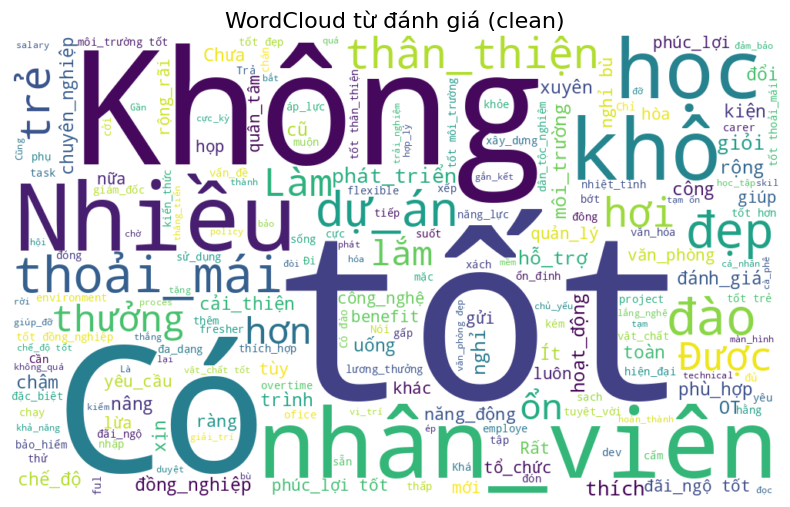

In [ ]:
text = " ".join(data["clean"].dropna().astype(str).tolist())

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud từ đánh giá (clean)", fontsize=16)
plt.show()

In [ ]:
#Vector hóa CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(data["clean"])
doc_term_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 80805 stored elements and shape (8411, 4160)>

In [ ]:
# Bước 4: Huấn luyện LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda.fit_transform(doc_term_matrix)

In [ ]:
lda_matrix

array([[0.94492936, 0.01366407, 0.01363313, 0.01390299, 0.01387045],
       [0.04125208, 0.04090571, 0.27531459, 0.60211728, 0.04041034],
       [0.59854622, 0.02052081, 0.02001224, 0.0210751 , 0.33984564],
       ...,
       [0.00682182, 0.00688612, 0.97264084, 0.00688995, 0.00676127],
       [0.01192028, 0.15205125, 0.81227503, 0.01184204, 0.0119114 ],
       [0.01074663, 0.79901754, 0.16884294, 0.01068386, 0.01070902]])

# Xác định x ,y

In [ ]:
X = doc_term_matrix
y = data['sentiment']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import  classification_report

# Dùng mô hình Naive Bayes

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state= 42)

In [ ]:
model = MultinomialNB()

In [ ]:
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(X_test)
score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred, average='macro')
print(score, recall, precision, f1)

0.7416798732171157 0.4392876304791343 0.5182992087569339 0.45736068665234825


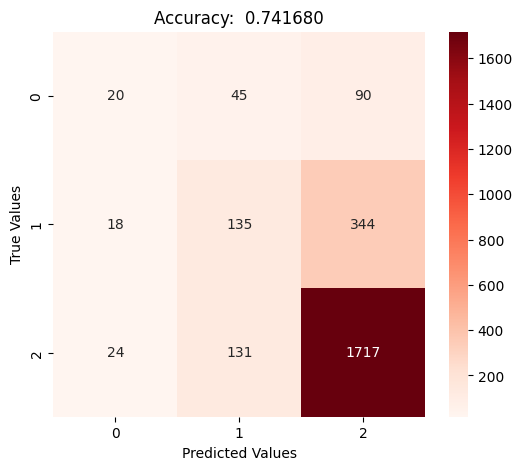

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
plt.title('Accuracy: {0: 3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.323     0.129     0.184       155
           1      0.434     0.272     0.334       497
           2      0.798     0.917     0.854      1872

    accuracy                          0.742      2524
   macro avg      0.518     0.439     0.457      2524
weighted avg      0.697     0.742     0.710      2524



# **Kết quả dự đoán thuộc nhóm 2 rất cao(tích cực) \**
# **--> các class thuộc nhóm 0 và 1 tỷ lệ đúng rất thấp**

# Xây dựng model Logistic Regression

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state= 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
print(model.intercept_)
print(model.coef_[0])

[-1.13938164  0.20449286  0.93488879]
[-0.13999193 -0.01782446 -0.00818528 ... -0.22294143  0.02275362
  0.24257104]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Đánh giá mô hình

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
acc = accuracy_score(y_test,y_pred)
print(score, recall, precision, acc)

0.7365293185419969 0.43599148424227935 0.5070448681895386 0.7365293185419969


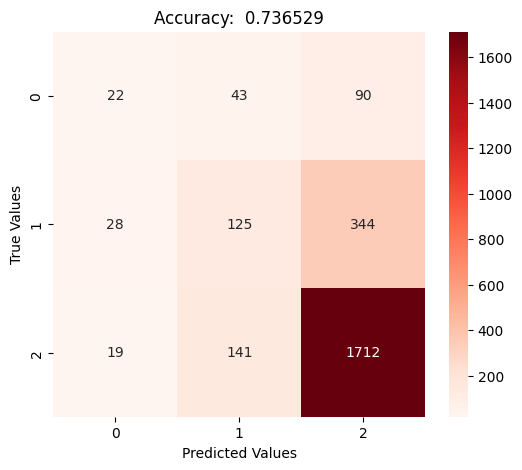

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
plt.title('Accuracy: {0: 3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.319     0.142     0.196       155
           1      0.405     0.252     0.310       497
           2      0.798     0.915     0.852      1872

    accuracy                          0.737      2524
   macro avg      0.507     0.436     0.453      2524
weighted avg      0.691     0.737     0.705      2524



# **Cũng như mô hình Navie Byes**
# **Kết quả dự đoán thuộc nhóm 2 rất cao(tích cực)**
# **--> các class thuộc nhóm 0 và 1 tỷ lệ đúng rất thấp**

# Sử dụng over_sampling tăng mẫu lên

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Tách feature và label
X = data.drop(columns=['sentiment'])
y = data['sentiment']

# Khởi tạo oversampler – chỉ oversample lớp 0- 2000, 1 - 3000
oversample = RandomOverSampler(sampling_strategy={0: 2000, 1: 3000}, random_state=42)

# Tạo dữ liệu mới sau khi oversample
X_resampled, y_resampled =  oversample.fit_resample(X, y)

# Kiểm tra lại phân phối sau khi xử lý
print("Phân phối ban đầu:", Counter(y))
print("Phân phối sau khi oversample:", Counter(y_resampled))

Phân phối ban đầu: Counter({2: 6203, 1: 1638, 0: 570})
Phân phối sau khi oversample: Counter({2: 6203, 1: 3000, 0: 2000})


In [ ]:
vectorizer1 = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix1 = vectorizer.fit_transform(X_resampled["clean"])
doc_term_matrix1

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 111584 stored elements and shape (11203, 5635)>

In [ ]:
X1 = doc_term_matrix1
y1= y_resampled

In [ ]:
X_train1 , X_test1 , y_train1, y_test1 = train_test_split(X1, y1, random_state=42)

# Thử lại Với model Navie Beys

In [ ]:
nvmodel = MultinomialNB()

In [ ]:
nvmodel.fit(X_train1, y_train1)

MultinomialNB()

In [ ]:
y_pred_nv = nvmodel.predict(X_test1)

In [ ]:
score = accuracy_score(y_test1,y_pred_nv)
precision = precision_score(y_test1,y_pred_nv,average='macro')
recall = recall_score(y_test1,y_pred_nv,average='macro')
acc = accuracy_score(y_test1,y_pred_nv)
print(score, recall, precision, acc)

0.7600856836843984 0.6949353182954523 0.7578003926564044 0.7600856836843984


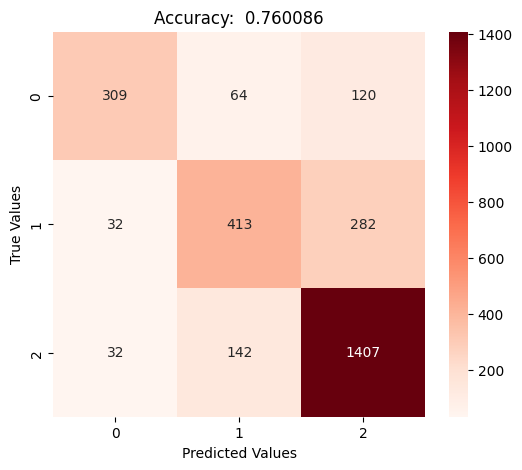

In [ ]:
cm = confusion_matrix(y_test1, y_pred_nv)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
plt.title('Accuracy: {0: 3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(classification_report(y_test1, y_pred_nv, digits=3))

              precision    recall  f1-score   support

           0      0.828     0.627     0.714       493
           1      0.667     0.568     0.614       727
           2      0.778     0.890     0.830      1581

    accuracy                          0.760      2801
   macro avg      0.758     0.695     0.719      2801
weighted avg      0.758     0.760     0.753      2801



# **Sau khi thay đổi mẫu, F1 của các class đều tăng**

# Thử lại model Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
lgmodel = LogisticRegression(class_weight='balanced', max_iter=1000)
lgmodel.fit(X_train1,y_train1)
print(model.intercept_)
print(model.coef_[0])

[-1.13938164  0.20449286  0.93488879]
[-0.13999193 -0.01782446 -0.00818528 ... -0.22294143  0.02275362
  0.24257104]


In [ ]:
# Đánh giá mô hình
y_pred = lgmodel.predict(X_test1)
score = accuracy_score(y_test1,y_pred)
precision = precision_score(y_test1,y_pred,average='macro')
recall = recall_score(y_test1,y_pred,average='macro')
acc = accuracy_score(y_test1,y_pred)
print(score, recall, precision, acc)

0.7650838986076401 0.7869100419734982 0.7450665115429 0.7650838986076401


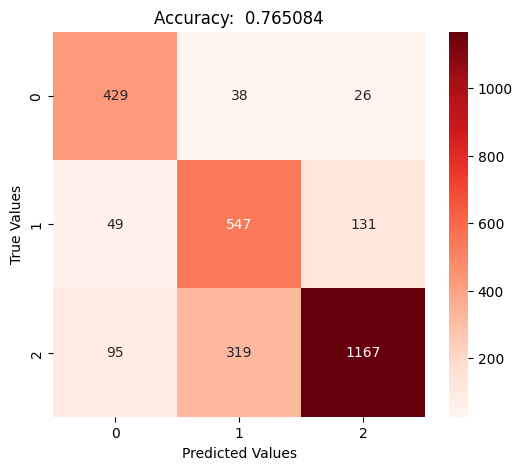

In [ ]:
cm = confusion_matrix(y_test1, y_pred)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
plt.title('Accuracy: {0: 3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(classification_report(y_test1, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.749     0.870     0.805       493
           1      0.605     0.752     0.671       727
           2      0.881     0.738     0.803      1581

    accuracy                          0.765      2801
   macro avg      0.745     0.787     0.760      2801
weighted avg      0.786     0.765     0.769      2801



# **Acc trong model Logistic cũng tăng đáng kể trong các class**

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knnModel = KNeighborsClassifier(n_neighbors=5)
knnModel.fit(X_train1, y_train1)

KNeighborsClassifier()

In [ ]:
y_pred = knnModel.predict(X_test1)
score = accuracy_score(y_test1,y_pred)
precision = precision_score(y_test1,y_pred,average='macro')
recall = recall_score(y_test1,y_pred,average='macro')
acc = accuracy_score(y_test1,y_pred)
print(score, recall, precision, acc)

0.5480185647982864 0.5974963726041714 0.5548008063607138 0.5480185647982864


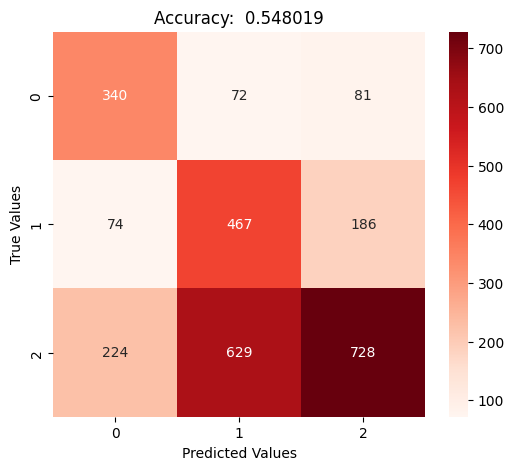

In [ ]:
cm = confusion_matrix(y_test1, y_pred)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
plt.title('Accuracy: {0: 3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(classification_report(y_test1, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.533     0.690     0.601       493
           1      0.400     0.642     0.493       727
           2      0.732     0.460     0.565      1581

    accuracy                          0.548      2801
   macro avg      0.555     0.597     0.553      2801
weighted avg      0.611     0.548     0.553      2801



# Thực hiện phân tích công ty

In [ ]:
data.groupby(by = ['id','Company Name'])['Rating'].agg(['count']).sort_values(by = 'count', ascending = False)

,,count
id,Company Name,
182,FPT Software,2014
306,NashTech,308
50,Bosch Global Software Technologies Company Limited,278
460,VNG Corporation,259
253,KMS Technology,251
...,...,...
250,KIS Việt Nam,3
318,NGS,3
382,Seven System Vietnam,3


In [ ]:
data_cty = data[data['id'] == 182].reset_index(drop=True)

In [ ]:
data_cty.loc[data_cty['sentiment'] == 2].head(3)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,text,clean,sentiment
0,182,FPT Software,December 2024,"If you have no experience or no where to go, t...","- Good working atmosphere and processes, espec...",- Every BULs must combine both performance and...,4,4,4,2,5,4,Yes,"If you have no experience or no where to go, t...",không_nghiệm proceses workers khổng_lồ chances...,2
2,182,FPT Software,May 2025,"Môi trường tốt, văn hóa đặc sắc","Môi trường chuyên nghiệp, người mới được hỗ tr...","Chế độ lương thưởng, phúc lợi chưa được hấp dẫ...",4,3,5,5,5,4,Yes,"Môi trường tốt, văn hóa đặc sắc- Môi trường ch...",tốt văn_hóa chuyên_nghiệp học OT chế_độ nghỉ b...,2
3,182,FPT Software,May 2025,Good enough for me,"Good co-worker. Good salary, not high, but goo...",They wont improve. That not how this company d...,4,4,4,2,4,5,No,Good enough for me- Good co-worker. Good salar...,salary cứng,2


In [ ]:
document = ' '.join(data_cty['clean'].astype(str))

In [ ]:
negative_count, negative_word_list = find_words(document, negative_words)
print("Number of negative words:", negative_count)
print("List of negative words:", negative_word_list)

Number of negative words: 1661
List of negative words: ['kém', 'tệ', 'buồn', 'chán', 'không thích', 'không ổn', 'chán', 'mệt', 'không hợp', 'không tốt', 'chậm', 'rườm rà', 'chán', 'gắt', 'kém', 'lỗi', 'mệt', 'ngắt', 'quát', 'rối', 'thiếu', 'trễ', 'tệ', 'tệp', 'tồi', 'áp', 'đáp', 'khó', 'không', 'chê', 'áp_lực', 'phân_biệt', 'lâu', 'ít', 'cực', 'ép', 'thiếu', 'mệt', 'xếp', 'lạnh', 'chậm', 'bất_công']


In [ ]:
# Phân tích tiêu cực
lda_neg = LatentDirichletAllocation(n_components=5).fit(vectorizer.fit_transform(negative_word_list))
# Hiển thị từ khóa đặc trưng negative(tiêu cực)
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_neg.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1] if i < len(feature_names)]
    print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

Chủ đề #1: không, kém, chậm, chán, mệt, thiếu, tệ
Chủ đề #2: mệt, kém, không, chậm, chán, thiếu, tệ
Chủ đề #3: chán, chậm, kém, không, mệt, thiếu, tệ
Chủ đề #4: thiếu, kém, không, chậm, chán, mệt, tệ
Chủ đề #5: tệ, kém, không, chậm, chán, mệt, thiếu


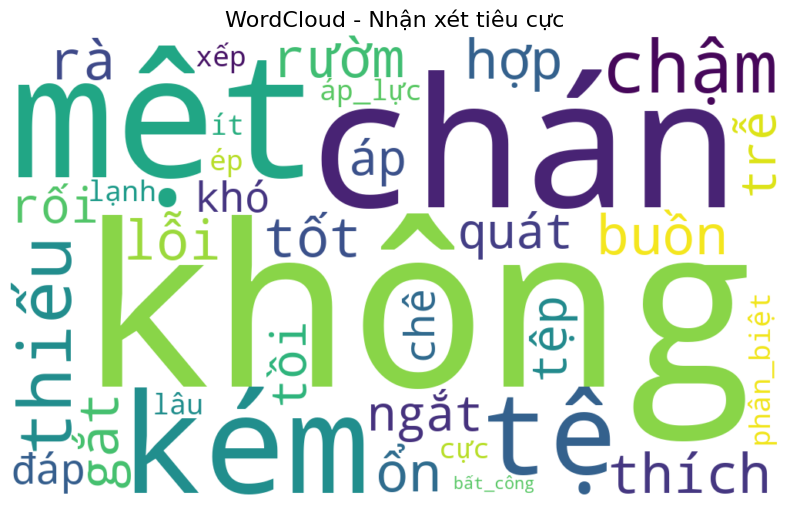

In [ ]:
text = ' '.join(map(str, negative_word_list))

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Nhận xét tiêu cực", fontsize=16)
plt.show()

In [ ]:
positive_count, positive_word_list = find_words(document, positive_words)
print("Number of positive words:", positive_count)
print("List of positive words:", positive_word_list)

Number of positive words: 4069
List of positive words: ['thích', 'tốt', 'ổn', 'rất tốt', 'rất thích', 'sáng tạo', 'chăm chỉ', 'chuyên', 'cảm', 'dễ', 'giỏi', 'hiệu', 'hài', 'hỗ trợ', 'nhiệt tình', 'sáng tạo', 'thân', 'thích', 'tuyệt', 'tốt', 'vui', 'ổn']


In [ ]:
# Phân tích tích cực
lda_pos = LatentDirichletAllocation(n_components=5).fit(vectorizer.fit_transform(positive_word_list))
# Hiển thị từ khóa đặc trưng positive
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_pos.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1] if i < len(feature_names)]
    print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

Chủ đề #1: sáng, tạo, ổn, rất, thích, tốt
Chủ đề #2: thích, rất, ổn, tốt, tạo, sáng
Chủ đề #3: tốt, rất, ổn, thích, tạo, sáng
Chủ đề #4: ổn, rất, thích, tốt, tạo, sáng
Chủ đề #5: ổn, rất, thích, tốt, tạo, sáng


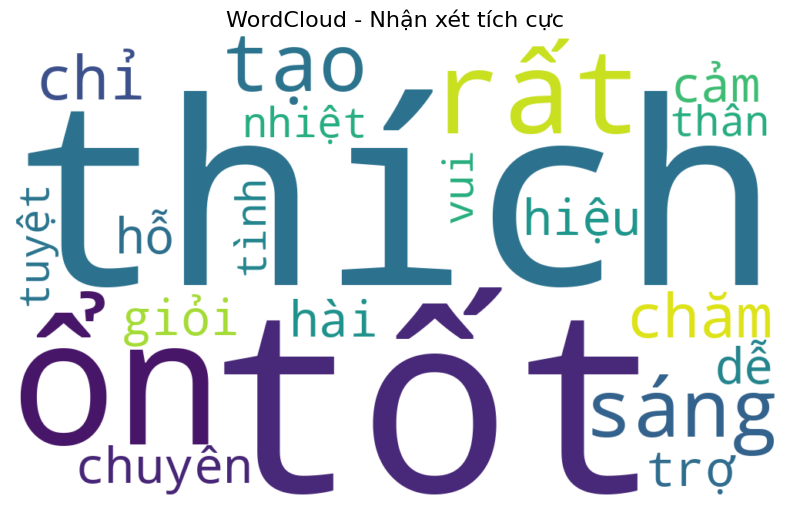

In [ ]:
text = ' '.join(map(str, positive_word_list))

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Nhận xét tích cực", fontsize=16)
plt.show()